# Variational Quantum EigenSolver

In [15]:
import numpy as np
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult
import matplotlib.pyplot as plt
from qiskit import quantum_info as qi
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob,StatevectorEstimator
from qiskit.circuit.library import TwoLocal,EfficientSU2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator

# Defining our Hamiltonian which we intend to minimize

In [16]:
hamiltonian =  SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)
print(hamiltonian.to_matrix())

[[-0.4093+0.j     0.    +0.j     0.    -0.398j  0.181 +0.j   ]
 [ 0.    +0.j    -0.3867+0.j     0.181 +0.j     0.    +0.398j]
 [ 0.    +0.398j  0.181 +0.j     0.4093+0.j     0.    +0.j   ]
 [ 0.181 +0.j     0.    -0.398j  0.    +0.j     0.3867+0.j   ]]


# Choosing our initial Ansatz

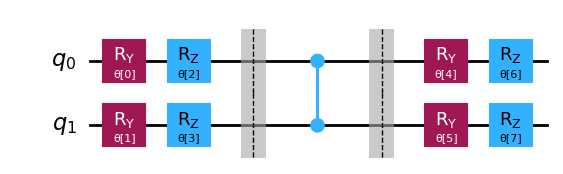

In [17]:
num_qubits = 2
rotation_blocks = ['ry','rz'] 
entanglement_blocks = 'cz'
entanglement = 'full'

ansatz = TwoLocal(2, rotation_blocks,entanglement_blocks ,entanglement, reps=1, insert_barriers=True)


### Don't change any code past this line ###
ansatz.decompose().draw('mpl')

ii) Transpiling our circuit to the backend we are using, in our case it is the IBM FakeSherbrooke()

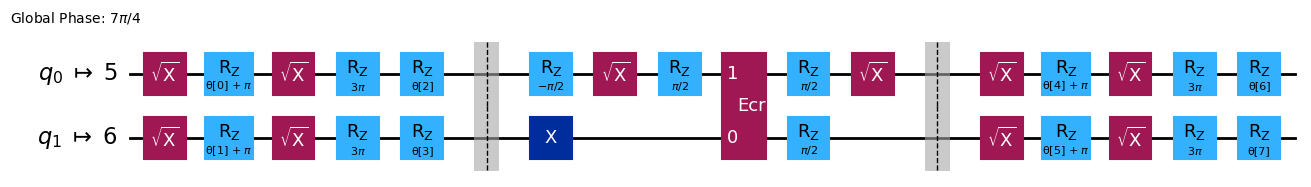

In [18]:
backend_answer = FakeSherbrooke()
optimization_level_answer = 3
pm = generate_preset_pass_manager(backend=backend_answer,optimization_level=optimization_level_answer)
isa_circuit = pm.run(ansatz)
isa_circuit.draw('mpl', idle_wires=False,) 

In [19]:
hamiltonian_isa = hamiltonian.apply_layout(layout=isa_circuit.layout)

# Defining our Cost function that is the expectation of our Hamiltonian operator

In [20]:
def cost_function(params,ansatz,operator,estimator):
    
    pub =  (ansatz, [operator], [params])
    result = estimator.run(pubs=[pub]).result()
    expectation = result[0].data.evs[0]
    
    return expectation

x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)

# Lets run our optimization loop which returns the optimized value of the parameters for which the cost function is minimum 

In [21]:
backend = FakeSherbrooke()
with Session(backend=backend) as session:
    estimator = Estimator(session=session)

    res = minimize(
        cost_function,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator),
        method="cobyla",
        options={'maxiter': 50})

/tmp/ipykernel_106963/4004008040.py:3: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(session=session)


# The result of our optimization

In [22]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -0.610925439453125
       x: [ 1.640e+00  9.153e-01  2.058e+00  8.626e+00  3.922e+00
            6.103e+00  6.708e+00  4.648e+00]
    nfev: 50
   maxcv: 0.0

In [25]:
print("THE GROUND STATE ENERGY OF OUR HAMILTONIAN WAS FOUND TO BE :",res.fun)

THE GROUND STATE ENERGY OF OUR HAMILTONIAN WAS FOUND TO BE : -0.610925439453125


# The ground state wavefunction of our hamiltonian

{'10': 93, '01': 492, '00': 339, '11': 100}


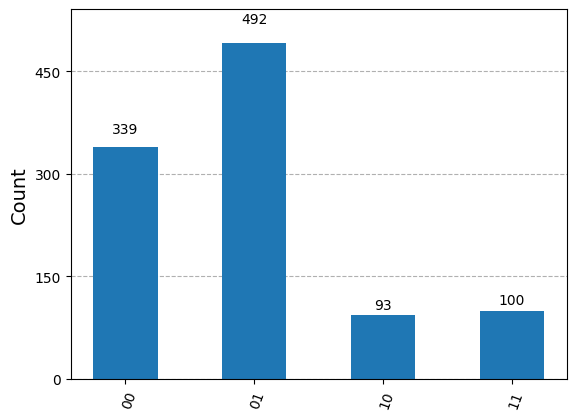

In [28]:
ansatz.measure_all()
sampler = StatevectorSampler()

params=res.x


pub = (ansatz,params) #Defining our PUB with quantum circuit,parameters(if present in circuit)
job_sampler = sampler.run([pub], shots=1024)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)
plot_histogram(counts_sampler)

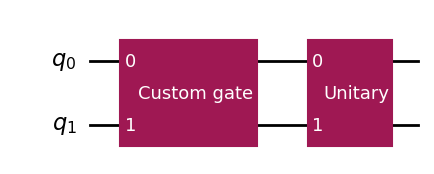